<a href="https://colab.research.google.com/github/AntonBaumannDE/fourier_features_MLP_tf2/blob/main/image_regression_fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains

Tinkering around with a fun paper. The implementation by the original authors helps with understanding on what's going on. 

Sources:

https://github.com/tancik/fourier-feature-networks

https://arxiv.org/pdf/2006.10739.pdf

In [1]:
import matplotlib.pyplot as plt
import os, imageio
from jax import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np

rand_key = random.PRNGKey(0)

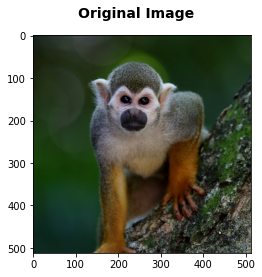

In [2]:
# Download image, take a square crop from the center
image_url = 'monkey.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

fig = plt.figure()
fig.suptitle('Original Image', fontsize=14, fontweight='bold')
plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)

x_test = np.stack(np.meshgrid(coords, coords), -1)

test_data = [x_test, img]
train_data = [x_test[::2,::2], img[::2,::2]]



In [3]:
# Create Model
model = models.Sequential()
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(3, activation='sigmoid'))


In [ ]:
import datetime
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_data[0], train_data[1], epochs=1000, 
                    validation_data=(test_data[0], test_data[1]), callbacks=[tensorboard_callback])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, None, 256)           768       
_________________________________________________________________
dense_1 (Dense)              (32, None, 256)           65792     
_________________________________________________________________
dense_2 (Dense)              (32, None, 256)           65792     
_________________________________________________________________
dense_3 (Dense)              (32, None, 3)             771       
Total params: 133,123
Trainable params: 133,123
Non-trainable params: 0
_________________________________________________________________


Unfortunately, a MLP with 133,123 params is not able to memorize an image with size of 256x256. It can not handle the required bandwith to represent such an image with the low-dimensional input of out xy-coordinate. The image appears blurred.

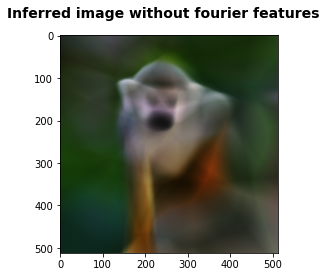

In [6]:
predictions = model.predict(test_data[0])
fig2 = plt.figure()
fig2.suptitle('Inferred image without fourier features', fontsize=14, fontweight='bold')
plt.imshow(predictions)

Tancik et al. observed how passing the input coordinates of a simple Fourier feature mapping enables our network to learn the high-frequency features in our low-dimensional problem domain.

In [7]:
# Fourier feature mapping
def input_mapping(x, B): 
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

In [8]:
input_size = 256
scale = 10
B = random.normal(rand_key, shape =(input_size, 2))*scale

In [9]:
# Create our Model again..
model = models.Sequential()
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(3, activation='sigmoid'))


In [ ]:
import datetime
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(input_mapping(train_data[0], B), train_data[1], epochs=1000, 
                    validation_data=(input_mapping(test_data[0], B), test_data[1]), callbacks=[tensorboard_callback])

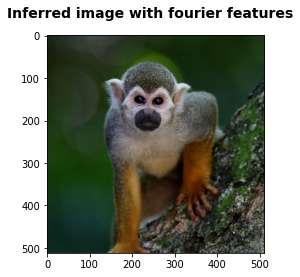

In [11]:
predictions = model.predict(input_mapping(test_data[0], B))
fig2 = plt.figure()
fig2.suptitle('Inferred image with fourier features', fontsize=14, fontweight='bold')
plt.imshow(predictions)